<a href="https://colab.research.google.com/github/ThomasTaylor14/Sim_Based_Project2/blob/main/youtube_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install particles

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for particles: filename=particles-0.3-py3-none-any.whl size=84623 sha256=394020c60199143c691a0996c13c49341488bf8f233538dc1abeef1103648712
  Stored in directory: /root/.cache/pip/wheels/25/6a/70/6bcbc856be79909999ad4fb66bfd8caf3f0da9f2dac83daea8
Successfully built particles


In [14]:
!pip install --upgrade particles


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import particles
from particles import distributions as dists  
from particles import state_space_models as ssm  
from particles.collectors import Moments 
from particles import mcmc  

In [4]:
class ShiftedBinomial(dists.DiscreteDist):
    """Shifted Binomial(n,p) distribution."""
    def __init__(self, n=1, p=0.5, loc=0):
        self.n = n
        self.p = p
        self.loc = loc

    def rvs(self, size=None):
        return stats.binom.rvs(self.n, self.p, loc = self.loc, size = size)

    def logpdf(self, x):
        return stats.binom.logpmf(x, self.n, self.p, self.loc)

    def ppf(self, u):
        return stats.binom.ppf(u, self.n, self.p, self.loc)


# question 1 

In [5]:
df=pd.read_csv('youtube.csv')

In [7]:
df.columns

Index(['Year', 'Monthly active users'], dtype='object')

In [8]:
df = df.rename(columns={'Monthly active users': 'Monthly_active_users'})


In [9]:
df.head()

,Year,Monthly_active_users
0,2005,1946322
1,2006,19878248
2,2007,143932250
3,2008,294493950
4,2009,413611440


# question 2 

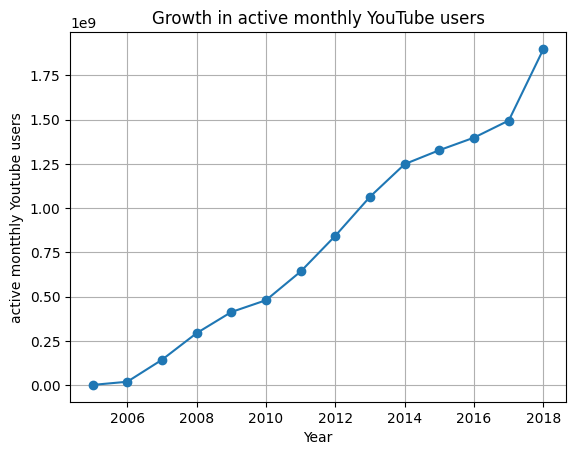

In [12]:
import matplotlib.pyplot as plt

# Données d'exemple
#years = [2018, 2019, 2020, 2021, 2022, 2023]
#monthly_active_users = [1000, 1200, 1500, 2000, 1800, 2500]

# Tracer les séries chronologiques
plt.plot(df.Year, df.Monthly_active_users, marker='o')

# Titres et labels des axes
plt.title('Growth in active monthly YouTube users')
plt.xlabel('Year')
plt.ylabel('active montthly Youtube users')

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()


# question 3

In [18]:
import numpy as np
from scipy.stats import binom, truncnorm
from particles import state_space_models

class BassModel(state_space_models.StateSpaceModel):
    def __init__(self, N, beta0, alpha, beta, sigma):
        self.N = N
        self.beta0 = beta0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma

    def PX0(self):
        return binom.rvs(self.N, self.beta0)

    def PX(self, t, xp):
        return ShiftedBinomial(self.N - xp, self.alpha + self.beta * xp / self.N)

    def PY(self, t, xp, x, y):
        return truncnorm.rvs((x - y) / self.sigma, np.inf, loc=x, scale=self.sigma)


# question 4

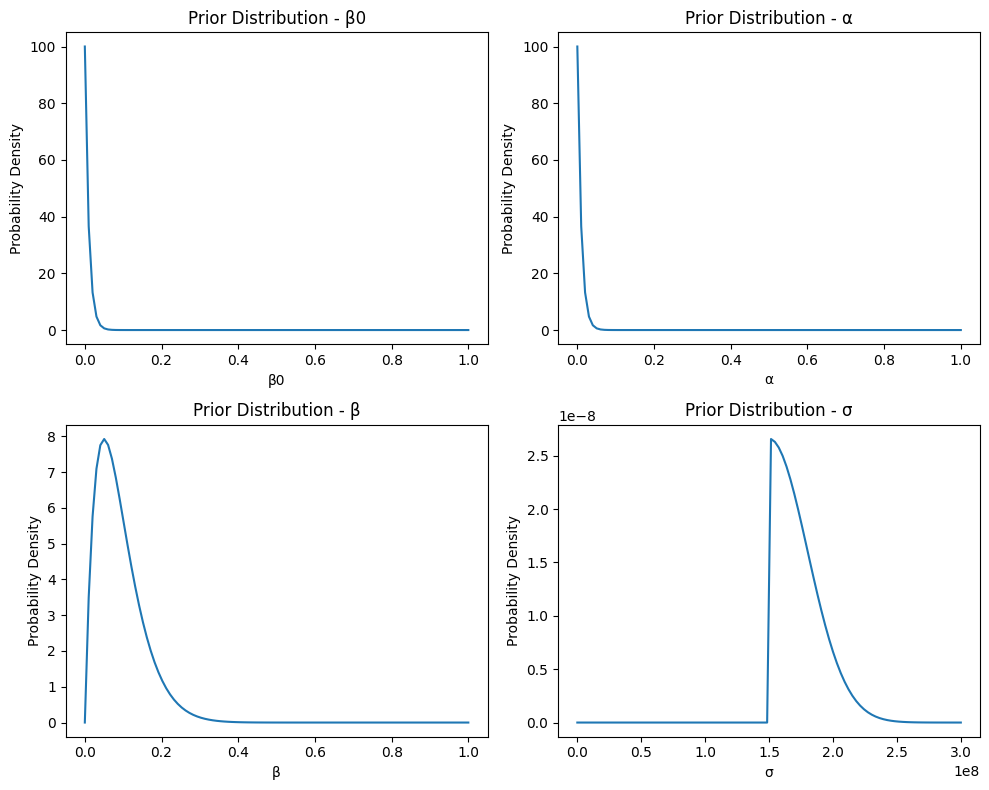

In [20]:
import numpy as np
from scipy.stats import beta, truncnorm
import matplotlib.pyplot as plt

# Define the prior distributions
beta0 = beta(a=1, b=100)
alpha= beta(a=1, b=100)
beta= beta(a=2, b=20)
sigma = truncnorm(a=(1.5e8 - 1.5e8) / (0.3e8), b=np.inf, loc=1.5e8, scale=0.3e8)

# Define the parameter ranges for plotting
beta0_range = np.linspace(0, 1, 100)
alpha_range = np.linspace(0, 1, 100)
beta_range = np.linspace(0, 1, 100)
sigma_range = np.linspace(0, 3e8, 100)

# Calculate the prior probability densities
beta0_prior_pdf = beta0.logpdf(beta0_range)
alpha_prior_pdf = alpha.logpdf(alpha_range)
beta_prior_pdf = beta.logpdf(beta_range)
sigma_prior_pdf = sigma.logpdf(sigma_range)

# Plot the prior probability density functions
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.plot(beta0_range, np.exp(beta0_prior_pdf))
plt.title('Prior Distribution - β0')
plt.xlabel('β0')
plt.ylabel('Probability Density')

plt.subplot(222)
plt.plot(alpha_range, np.exp(alpha_prior_pdf))
plt.title('Prior Distribution - α')
plt.xlabel('α')
plt.ylabel('Probability Density')

plt.subplot(223)
plt.plot(beta_range, np.exp(beta_prior_pdf))
plt.title('Prior Distribution - β')
plt.xlabel('β')
plt.ylabel('Probability Density')

plt.subplot(224)
plt.plot(sigma_range, np.exp(sigma_prior_pdf))
plt.title('Prior Distribution - σ')
plt.xlabel('σ')
plt.ylabel('Probability Density')

plt.tight_layout()
plt.show()


The prior distributions chosen for β0, α, and β are relatively non-informative, allowing for a wide range of possible parameter values. This may be appropriate when there is little prior knowledge or when it is desired to be conservative and let the data strongly influence the parameter estimation.

To reflect the prior assumption that measurement errors follow a normal distribution with a center at 1.5 108, the TruncNormal distribution is employed for. This distribution effectively models the measurement noise and incorporates the measurement process's uncertainty.

# question 5

In [21]:
import numpy as np
from scipy.stats import beta, truncnorm
from particles import pmcmc

# Define the prior distributions
beta0_prior = beta(a=1, b=100)
alpha_prior = beta(a=1, b=100)
beta_prior = beta(a=2, b=20)
sigma_prior = truncnorm(a=(1.5e8 - 1.5e8) / (0.3e8), b=np.inf, loc=1.5e8, scale=0.3e8)

# Define the likelihood function p(y|θ)
def likelihood(theta, y):
    # Implement your likelihood function here
    # Given the parameters theta and the data y,
    # compute the likelihood p(y|θ)
    pass

# Define the log posterior function p(θ|y) up to a constant
def log_posterior(theta, data):
    beta0, alpha, beta, sigma = theta
    y = data
    
    # Compute the log prior probability
    log_prior = (
        beta0_prior.logpdf(beta0) +
        alpha_prior.logpdf(alpha) +
        beta_prior.logpdf(beta) +
        sigma_prior.logpdf(sigma)
    )
    
    # Compute the log likelihood
    log_likelihood = likelihood(theta, y)
    
    # Compute the log posterior probability
    log_posterior = log_prior + log_likelihood
    
    return log_posterior

# Define the number of particles and iterations
num_particles = 20
num_iterations = 5000

# Define the data y0, y1, ..., y13
data = df  # Insert your data here

# Initialize the PMMH algorithm
algorithm = pmcmc.PMMH(num_particles, log_posterior, data)

# Run the PMMH algorithm
algorithm.run(num_iterations)

# Obtain the posterior samples
posterior_samples = algorithm.get_posterior_samples()




ImportError: ignored